
$$\newcommand{\vec}[1]{{\bf #1} } 
\newcommand{\real}{\mathbb{R} }
\newcommand{\expect}[1]{\mathbb{E}[#1] }
\DeclareMathOperator*{\argmin}{arg\,min}
\DeclareMathOperator*{\argmax}{arg\,max}
\newcommand{\E}{\mathbb{E}}$$

### ELEC-E7851: Computational User Interface Design 
### Fall 2021

<img src="images/performance.png" width="25%" align="right">


# Lecture 3: Human Performance Modeling

### Antti Oulasvirta, Aalto University
*Email: antti.oulasvirta@aalto.fi*

This notebook reviews models of human performance in interactive tassk. The models cover basics of motor control, attention, and choice. 

### Engineering models
The models presented here are **engineering models**. Engineering models are used to predict human performance under conditions related to design, task, and the user. As opposed to **scientific models** where the prime goal is validity, the main purpose here applicability in decision-making and design. They are formulated mathematically, for exampla using regression, and contain three types of variables: (1) those describing task conditions, (2) those describing predictions regarding human performance, and (3) free parameters. Engineering models normally have fewer free parameters than scientific models. Their focus is on capturing _just enough_ variance with minimum assumptions. Simplicity helps when (1) fitting models to data, (2) editing them to improve them, and (3) using them computationally for example in computational design or adaptation. 

### Modeling workflow

How are such models created in the first place? The paper [Ten simple rules for the computational modeling of behavioral data](https://elifesciences.org/articles/49547) describes the steps. In this notebook, we focus on understanding elements of models rather than how they are constructed.

### This notebook: Case and learning objectives

We continue inspecting the menu system as our case. Menu is a special case of graphical interaction with one degree of freedom in movement (up or down). It is sufficiently complex to have contributions from motor control, attention, strategy, and learning. The associated slide deck provides a more comprehensive overview of human performance models. 

Our objective in this notebook is to get familiar with **statistical models** of human performance, where the relationship between conditions and performance is described with a low number of parameters. In the next lecture, we will focus on **simulator models** where the solution of an interactive problem is simulated in a step-by-step manner.  

### Contents
1. Aimed movements: Fitts' law
2. Choice reaction: Hick's law
3. Search: Linear scanning model
4. Search: Recall model
5. Search: Foraging model

<img src="images/menus.png" width="85%">

Source: 
* Most of the modeling assumptions are based on [Bailly et al. CHI'14](https://hal.sorbonne-universite.fr/hal-01820441/document)

<p>
<div class="alert alert-block alert-danger"> 
<h3>Missing code cell</h3> 
<br>
The implementation of Hick's law is left blank as an exercise.
</div>
</p>

---

# 1. Aimed movements: Fitts' law

<img src="images/fitts.png" width="65%" align="center">

**Recap:** Fitts' law is a model of _aimed movements_. A single end-effector is to be moved on top of a spatially bounded target. The target has width W and distance D. Here movement time is given as:

$$ MT = a + b ID = a + b log_2 (D/W + 1) $$

In the following, we assume empirical parameters a and b to be given. Width W, on the other hand, is constant so we can ignore it. 

Model of menu behavior:
* Expected selection time is the weighted sum of movement times

In [1]:
import utilities
from collections import Counter

menu = ["save", "help", "-", "about","print","-","save-as","open-URL", "share", "close","-","open"]
associations = { "open": {"open": 1.0, "open-URL": 0.7, "save": 0.5, "save-as": 0.2, "close": 0.3}, 
                 "save": {"save": 1.0, "save-as": 0.6, "close": 0.2, "open": 0.5, "open-URL": 0.2}, 
                 "open-URL": {"open-URL": 1.0, "open": 0.7, "save": 0.5, "save-as": 0.2, "close": 0.3},
                 "save-as": {"save as": 1.0, "save": 0.8, "close": 0.1, "open": 0.2, "open-URL": 0.1},
                 "close": {"close": 1.0, "open": 0.2, "save":0.2}, "help": {"help": 1.0, "about": 0.2}, 
                 "about": {"about":1.0, "help": 0.1}, 
                 "print": {"print":1.0, "share": 0.2}, 
                 "share": {"share":1.0, "print": 0.2} 
               }

utilities.showmenu(menu)



Output()

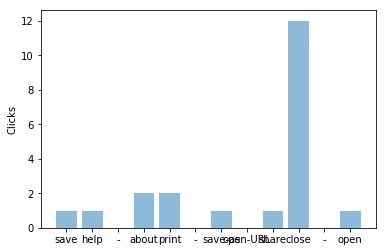

In [3]:
frequencies = utilities.parsedata()
utilities.plothistogram(menu)

In [4]:
import numpy as np
import math, random

# We have changed the objective structure a bit from last lecture
# Fitts' law is taken away from the objective function to a separate function
def fitts(distance, frequency, *params):
    # a - empirical parameter, "non-informative cost"
    # b - empirical parameter, "informative cost"
    # distance - distance from the top of the menu
    # frequency is not used yet (see fitts_learning)
    a = params[0][0]
    b = params[0][1]    
    return a + b * math.log (distance + 1)

# A generic handler for objective functions
def objective(menu, frequencies, *params):
    st_sum = 0.0
    for i in range (0, len(menu)):
        st_sum += fitts(i, frequencies[i], *params) * frequencies[menu[i]]
    return st_sum / sum(frequencies.values())

# A generic handler for testing objective functions
def test(menu, frequencies, objective, *params):
    print ("command   prediction")
    for i in range (0, len(menu)):
        value = objective(i, frequencies[menu[i]], *params)
        print ("{:8s}  {:0.2f} s".format(menu[i], value))

params = [0.3, 0.5] # a and b of Fitts' law
test (menu, frequencies, fitts, params)

command   prediction
save      0.30 s
help      0.65 s
-         0.85 s
about     0.99 s
print     1.10 s
-         1.20 s
save-as   1.27 s
open-URL  1.34 s
share     1.40 s
close     1.45 s
-         1.50 s
open      1.54 s


In [5]:
# Let's optimize a menu using this model

# Random search solver from lecture 3
def optimizer (max_iters, seed_menu, frequencies, associations, params):
    bestknown_value = float('inf')
    bestknown_design = []
    for i in range (0, max_iters):
        candidate = random.sample(seed_menu, len(seed_menu))
        objective_value = objective(candidate, frequencies, params) 
        if objective_value < bestknown_value: # minimize
            bestknown_value = objective_value
            bestknown_design = candidate
    return bestknown_value, bestknown_design

bestvalue, bestmenu = optimizer (100000, menu, frequencies, associations, params)
print (bestvalue, "\n", bestmenu)

0.5680991448175751 
 ['close', 'print', 'about', 'open', 'save', 'help', 'save-as', 'share', '-', '-', 'open-URL', '-']


In [6]:
utilities.showmenu(bestmenu)

Output()

## Motor learning (Power law of practice) 

<img src="images/powerlaw.png" width="35%" align="right">

How to take the improvement of performance over time into account?
[**Power law of practice**](https://www.nngroup.com/articles/power-law-learning/) models the change in motor performance with repetitions.

> "The power law of practice states that the logarithm of the reaction time for a particular task decreases linearly with the logarithm of the number of practice trials taken." (Wikipedia) 

Power law formulation:
$$ T = aP^{−b} + c $$

Exponential formulation:
$$ T = ae^{−b(P-1)} + c $$

where
* T = trial completion time
* P = trial number
* a, b, and c, are empirical parameters. 

Model of menu behavior:
* Same as the Fitts' model, but MT is modified by the number of previous encounters with the item 

In [7]:
def fitts_learning(distance, frequency, *params):
    a = params[0][0]
    b = params[0][1]
    b_pll = params[0][2] # learning parameter
    MT = a + b * math.log(distance+1) * math.exp(- b_pll * (frequency-1))
    return MT


params = [0.4, 0.3, 0.2]
test (menu, frequencies, fitts, params)
test (menu, frequencies, fitts_learning, params)




command   prediction
save      0.40 s
help      0.61 s
-         0.73 s
about     0.82 s
print     0.88 s
-         0.94 s
save-as   0.98 s
open-URL  1.02 s
share     1.06 s
close     1.09 s
-         1.12 s
open      1.15 s
command   prediction
save      0.40 s
help      0.61 s
-         0.80 s
about     0.74 s
print     0.80 s
-         1.06 s
save-as   0.98 s
open-URL  1.16 s
share     1.06 s
close     0.48 s
-         1.28 s
open      1.15 s


<p>
<div class="alert alert-block alert-success"> 
<h3>Discussion</h3> 
<br>
What would happen if we optimized a menu using fitts_learning as the objective function?
</div>
</p>

---

# 2. Choice reaction: Hick's law

Hick-Hyman law is a model of **choice reaction time (CRT)**. It describes the relationship between number of options one chooses from and choice time. 

$$T=b \cdot \log _{{2}}(n+1)$$

where n is the number of options and b is an empirical parameter. In the case of unequal propabilities, the model becomes

$$ T = bH = H=\sum _{i}^{n}p_{i}\log _{{2}}(1/p_{i}+1)$$

In conditions of _stimulus--response compatibility_, processing speed should be higher. 

<p>
<div class="alert alert-block alert-success"> 
<h3>Exercise</h3> 
<br>
Implement a Hick's law model for a menu with subgroups. **Tips:** Assume that the user starts from the top and must decide for each _subgroup_ if the target is there or not. Decision time for each subgroup is given by Hick's law. Total cost is then the sum of Hick-decision times until the user arrived to the subgroup that contains the target. 
</div>
</p>

Comment from student Abhishek Kumar: Hick’s law has been criticized in this recent CHI paper! Liu, W., Gori, J., Rioul, O., Beaudouin-Lafon, M., & Guiard, Y. (2020, April). How Relevant is Hick's Law for HCI?. In Proceedings of the 2020 CHI Conference on Human Factors in Computing Systems (pp. 1-11).

In [ ]:
def hicks(distance, frequency, *args):
    menu = args[0][0]
    frequencies = args[0][1]
    b = args[0][2]
    
    # add your model here     
    # for ...
    #
    # tip: sum(frequencies.values()) gives you total number of clicks

    T = 0

    return T


params = [menu, frequencies, 0.3]
test (menu, frequencies, hicks, params)

<p>
<div class="alert alert-block alert-success"> 
<h3>Discussion</h3> 
<br>
Why is this model too optimistic, i.e. gives too high performance estimations?
</div>
</p>

# 3: Search: Linear search

**Linear search** refers to the top-to-bottom inspection of items. Items are inspected one at a time and a time cost is paid for each inspection. Items that appear after the target are not visited. With practice, users not only skip more items but also spend less time on each visited item. 


In [10]:
# time cost for reading an item
# time cost decreases with number of encounters
def read (n_encounters, a_s = 0.3, b_s = 0.3):     
    return a_s + a_s * math.exp(- b_s * n_encounters)

def scan(targetindex, n_encounters, *params):
    a_s = params[0][0] 
    b_s = params[0][1] # Set this to zero to have a novice model
    t = 0.0
    for i in range (0, targetindex+1):
        t += read(n_encounters+1, a_s, b_s)
    return round(t,3)

params = [0.3, 0.2]
test (menu, frequencies, scan, params)


command   prediction
save      0.50 s
help      1.00 s
-         1.64 s
about     1.86 s
print     2.32 s
-         3.27 s
save-as   3.51 s
open-URL  4.37 s
share     4.51 s
close     3.22 s
-         6.00 s
open      6.01 s


<p>
<div class="alert alert-block alert-success"> 
<h3>Discussion</h3> 
<br>
How does manipulation of b_s affect predictions? 
</div>
</p>

# 4. Search: Recall

In **recall-based search**, the user tries to glance directly at the target.  Attempts are initially more random, but become more accurate with time. As an experienced user has memory about the location of the target, he/she can glance at the neighborhood of the target and, eventually, directly move the eyes to it. We assume that if this attempt fails, the user must scan the list from the beginning to find the target (penalty). 

In [11]:
# Recall
def recall(target, n_encounters, *params):    
    menu = params[0][0] 
    a_s = params[0][1]
    b_s = params[0][2]
    b_r = params[0][3]
    
    recall_probability = 1.0 - math.exp(-b_r * (n_encounters+1))
    t = read(n_encounters, a_s, b_s)

    if random.random() > recall_probability: # if recall fails
        t *= target                          # penalty must be paid
    return round(t,3)

params = [menu, 0.3, 0.2, 0.2]
test (menu, frequencies, recall, params)


command   prediction
save      0.00 s
help      0.55 s
-         1.20 s
about     1.50 s
print     0.50 s
-         3.00 s
save-as   3.27 s
open-URL  4.20 s
share     0.55 s
close     2.94 s
-         6.00 s
open      6.00 s


<p>
<div class="alert alert-block alert-success"> 
<h3>Exercise</h3> 
<br>
Create a rational time-minimizing user model that switches to recall as soon as it becomes more efficient than using scanning.
</div>
</p>

# 5. Search: Foraging

**Information foraging theory** posits that in interaction people exchange their time to obtain information. Decisions on how to pursue these are governed by (1) information allowed by available actions and (2) the time or effort needed to in each action. The theory propounds that interactive behavior develops to maximize the rate of information gained per unit of time (or effort) invested. In other words, in foraging, information gains are proportionate to time expended:

$$\mbox{information gained} \propto \mbox{time used}$$

We implement **a foraging policy** for menu search. The user is assumed to obtain 'a scent' of a subgroup based on the first item (anchor). If that item is related to the target, it continues in that subgroup. If not, it continues.

Policy:
1. Look at an item
2. If it is related to the target, keep reading the present subgroup one item at a time.
3. If it is *not* related, skip to the next subgroup.
4. If the target is found, stop.
5. If the end of the  menu is reached, pay penalty.

In [10]:
def forage (target, frequency, *params):
    menu = params[0][0] 
    associations = params[0][1]
    item_cost = params[0][2]
    group_cost = params[0][3]
    
    t = 0.0
    groupboundary = False
    targetfound = False
    anchor = None
    
    for i in range (0, len(menu)):
        if menu[i] == "-": 
            groupboundary = True
            anchor = None
            continue
        if i==0:
            groupboundary = True
        if groupboundary and (menu[i] != "-"): # group starts
            t += item_cost # read the anchor of a group
            if menu[i] in list(associations.keys()) and (menu[target] in associations[menu[i]]):
                anchor = menu[i] # it is here
            elif menu[i] in list(associations.keys()) and (menu[target] not in associations[menu[i]]):
                anchor = None # it's not here: skip
                t += group_cost # group skipping penalty
            groupboundary = False
        elif groupboundary == False:
            if anchor != None:
                t += item_cost # read item in the group            
        if (anchor != None) and (i == target): # found!
            targetfound = True
            break
        elif (anchor != None) and (i != target) and (anchor not in associations[menu[i]].keys()):
            anchor = None # anchor lost
            t += item_cost # read item in the group
        elif (anchor == None):
            continue
    if not targetfound:
        t += item_cost * len(menu)/2.0 # scanning penalty 
    return round(t,3)

menu = ["save", "save-as", "-", "help","print","-","about","open-URL", "share", "close","-","open"]
params = [menu, associations, 0.3, 0.4]
test (menu, frequencies, forage, params)


command   prediction
save      0.30 s
save-as   0.60 s
-         4.60 s
help      1.00 s
print     4.60 s
-         4.60 s
about     1.90 s
open-URL  4.10 s
share     4.60 s
close     4.10 s
-         4.60 s
open      2.30 s


In [15]:
def optimizer (max_iters, seed_menu, frequencies, associations, params):
    bestknown_value = float('inf')
    bestknown_design = []
    for i in range (0, max_iters):
        candidate = random.sample(seed_menu, len(seed_menu))
        objective_value = 0.0
        params = [candidate, associations, 0.3, 0.4]
        for j in range (0, len(menu)):
            objective_value += forage(j, frequencies[menu[j]], params) * frequencies[menu[j]]
        objective_value /= sum(frequencies.values())
        if objective_value < bestknown_value: # minimize
            bestknown_value = objective_value
            bestknown_design = candidate
    return bestknown_value, bestknown_design

bestvalue, menu = optimizer (40000, menu, frequencies, associations, params)
print (bestvalue, "\n", menu)

1.2075471698113207 
 ['-', '-', 'about', 'help', 'share', 'open-URL', '-', 'open', 'save', 'close', 'save-as', 'print']


In [16]:
utilities.showmenu(menu)

Output()